In [1]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob

In [2]:
image_directory = 'simage/'
mask_directory = 'slabel_binary/'

In [3]:
SIZE = (96,128,3)
num_images = 700

Load images and masks in order so they match

In [4]:
image_names = glob.glob("simage/*.png")
#print(image_names)

In [5]:
image_names.sort()
#print(image_names)

In [6]:
#image_names_subset = image_names[0:num_images]

In [7]:
images = [cv2.imread(img) for img in image_names]

In [8]:
image_dataset = np.array(images)
#image_dataset = np.expand_dims(image_dataset, axis = 4)

Read masks the same way. 

In [9]:
mask_names = glob.glob("slabel_binary/*.png")
mask_names.sort()
#mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask,0) for mask in mask_names]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [10]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (701, 96, 128, 3)
Mask data shape is:  (701, 96, 128, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


In [11]:
#scaler = MinMaxScaler()

In [12]:
#test_image_data=scaler.fit_transform(image_dataset_uint8.reshape(-1, image_dataset_uint8.shape[-1])).reshape(image_dataset_uint8.shape)

In [13]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler

mask_dataset = mask_dataset /255.  #PIxel values will be 0 or 1

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)


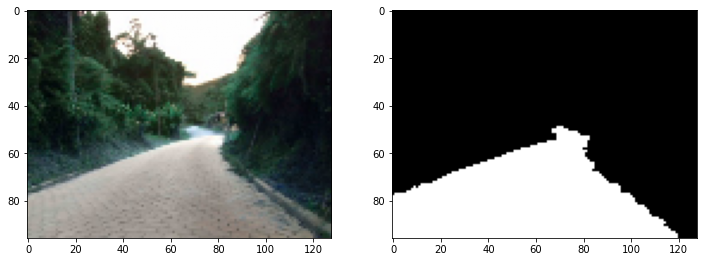

In [15]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,:])
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,:], cmap='gray')
plt.show()

In [16]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, concatenate, Dropout,\
                                    Lambda, Conv2DTranspose, Add
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow as tf
import os


def unet_model(input_size=(96, 128, 3), n_filters=5, n_classes=1):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
        
    """
    b = n_filters
    i = Input(input_size)
    
    # Contracting Path (encoding)
    c1 = Conv2D(2**b, (3, 3), activation='relu',padding='same') (i)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(2**b, (3, 3), activation='relu',padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(2**(b+1), (3, 3), activation='relu', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(2**(b+1), (3, 3), activation='relu',  padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(2**(b+2), (3, 3), activation='relu',  padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(2**(b+2), (3, 3), activation='relu',  padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(2**(b+3), (3, 3), activation='relu',  padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(2**(b+3), (3, 3), activation='relu',  padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(2**(b+4), (3, 3), activation='relu', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(2**(b+4), (3, 3), activation='relu', padding='same') (c5)
    
    # Expansion part (Decoding)
    
    u6 = Conv2DTranspose(2**(b+3), (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(2**(b+3), (3, 3), activation='relu', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(2**(b+3), (3, 3), activation='relu',  padding='same') (c6)

    u7 = Conv2DTranspose(2**(b+2), (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(2**(b+2), (3, 3), activation='relu',  padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(2**(b+2), (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(2**(b+1), (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(2**(b+1), (3, 3), activation='relu',  padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(2**(b+1), (3, 3), activation='relu',  padding='same') (c8)

    u9 = Conv2DTranspose(2**b, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(2**b, (3, 3), activation='relu', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(2**b, (3, 3), activation='relu',  padding='same') (c9)

    o = Conv2D(n_classes, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=i, outputs=o)
    return model

In [17]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(96, 128, 3)


In [18]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
unet.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
unet.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 128, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 96, 128, 32)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 128, 32)  9248        dropout[0][0]                    
_______________________________________________________________________________________

In [19]:
history = unet.fit(X_train, y_train, 
                    batch_size = 20, 
                    verbose=1, 
                    epochs=5, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)


Epoch 1/5
28/28 [==============================] - 139s 5s/step - loss: 0.6261 - accuracy: 0.6463 - val_loss: 0.4327 - val_accuracy: 0.6647
Epoch 2/5
28/28 [==============================] - 135s 5s/step - loss: 0.3747 - accuracy: 0.7536 - val_loss: 0.3105 - val_accuracy: 0.9024
Epoch 3/5
28/28 [==============================] - 134s 5s/step - loss: 0.2519 - accuracy: 0.9063 - val_loss: 0.1730 - val_accuracy: 0.9307
Epoch 4/5
28/28 [==============================] - 137s 5s/step - loss: 0.1512 - accuracy: 0.9336 - val_loss: 0.1255 - val_accuracy: 0.9459
Epoch 5/5
28/28 [==============================] - 133s 5s/step - loss: 0.1364 - accuracy: 0.9435 - val_loss: 0.1235 - val_accuracy: 0.9537


In [20]:
#Save the model for future use
unet.save('unet_5ep.h5')

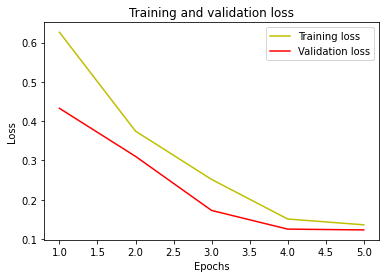

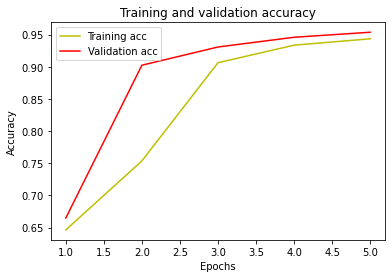

In [21]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
#Load previously saved model
from keras.models import load_model
model = load_model("unet_5ep.h5", compile=False)
        

In [23]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

In [24]:
from tensorflow.keras.metrics import MeanIoU

In [25]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.9005519


In [26]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

import matplotlib.pyplot as plt
import cv2
import numpy as np

import skimage.io
import skimage.feature
import skimage.color
import skimage.transform
import skimage.util
import skimage.segmentation
import numpy
from skimage.segmentation import mark_boundaries

In [36]:
# shows outputs of random Images
def show_results(n):
    for i in range(n):
        threshold = 0.5
        test_img_number = random.randint(0, len(X_test)-1)
        test_img = X_test[test_img_number]
        ground_truth=y_test[test_img_number]
        test_img_input=np.expand_dims(test_img,0)
        print(test_img_input.shape)
        prediction = (model.predict(test_img_input)[0,:,:,:] > 0.5).astype(np.uint8)
        print(prediction.shape)

        img = test_img[:,:,:]

        plt.figure(figsize=(16, 8))
        plt.subplot(231)
        plt.title('Testing Image')
        plt.imshow(test_img[:,:,:])
        plt.subplot(232)
        plt.title('Testing Label')
        plt.imshow(ground_truth[:,:,0],)
        plt.subplot(233)
        plt.title('Prediction on test image')
        plt.imshow(prediction,)
        plt.show()

(1, 96, 128, 3)
(96, 128, 1)


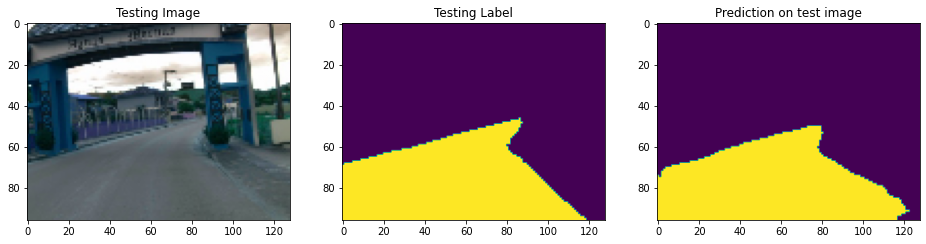

(1, 96, 128, 3)
(96, 128, 1)


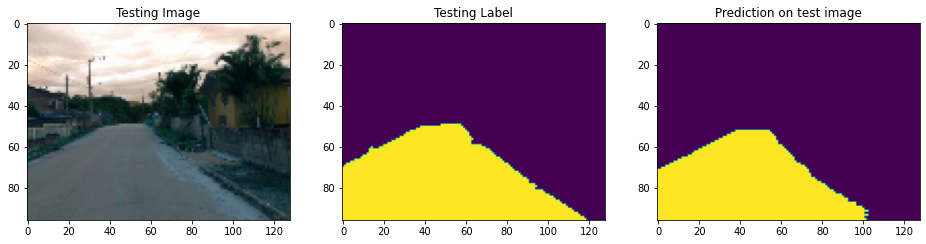

(1, 96, 128, 3)
(96, 128, 1)


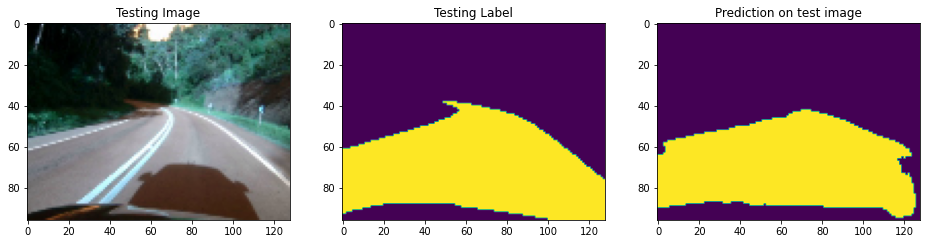

(1, 96, 128, 3)
(96, 128, 1)


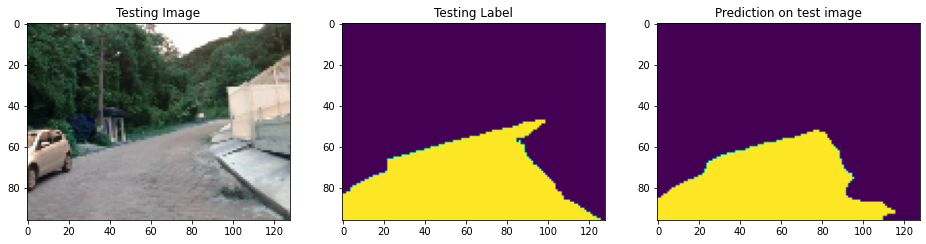

(1, 96, 128, 3)
(96, 128, 1)


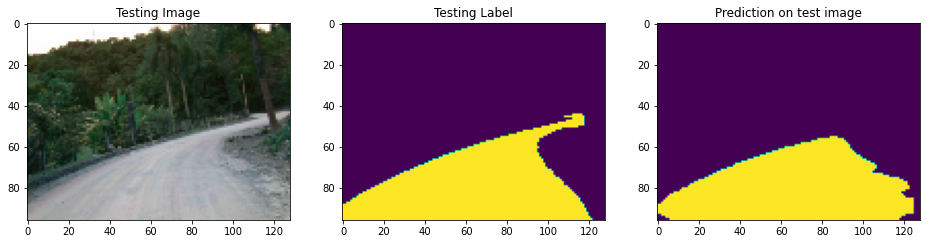

(1, 96, 128, 3)
(96, 128, 1)


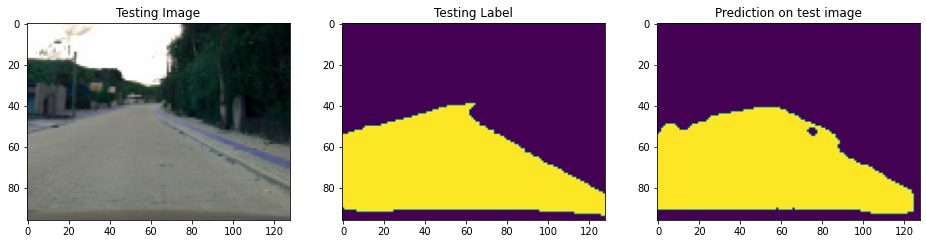

In [41]:
show_results(6)

### In 4th image the model is able to detect hole in the road even it is labeled incorrectly... :)